In [ ]:
!pip install wandb

In [1]:
import os
import time
import json
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import kagglehub

import timm

import wandb
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from collections import Counter


In [8]:
# Download latest version
path = kagglehub.dataset_download("nunenuh/pytorch-challange-flower-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pytorch-challange-flower-dataset' dataset.
Path to dataset files: /kaggle/input/pytorch-challange-flower-dataset


In [23]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

DATA_DIR = os.path.join(path, "dataset")

NUM_CLASSES = 102
BATCH_SIZE = 32
EPOCHS = 20
FREEZE_EPOCHS = 5
LR = 3e-4
img_size = 224


Device: cpu


In [ ]:

os.environ["WANDB_API_KEY"] = "WANDB_API_KEY"

wandb.login()

wandb.init(
    project="CNN-Flower-Classification",
    config={
        # DATA
        "dataset": "Kaggle-Flowers102",
        "num_classes": 102,
        "input_size": 224,

        # MODEL
        "model": "ConvNeXt-Base",
        "pretrained": "ImageNet-1K",
        "classifier_head": "Linear",

        # TRAINING
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "freeze_epochs": FREEZE_EPOCHS,

        # OPTIMIZER
        "optimizer": "AdamW",
        "learning_rate": LR,
        "weight_decay": 1e-4,

        # SCHEDULER
        "scheduler": "CosineAnnealingLR",

        # AUGMENTATION
        "augmentation": [
            "RandomResizedCrop",
            "HorizontalFlip",
            "Rotation",
            "ColorJitter"
        ]
    },
    name=f"ConvNeXt-KaggleFlowers-{time.strftime('%Y%m%d-%H%M%S')}",
)


config = wandb.config
print(f"wandb run: {wandb.run.name}")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.
wandb: Currently logged in as: tuankiet1302051 (tuankiet1302051-fpt-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb run: ConvNeXt-KaggleFlowers-20260130-132338


In [10]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [11]:
# LOAD DATASET

train_set = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "train"),
    transform=train_tf
)

val_set = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "valid"),
    transform=val_tf
)


# DATALOADERS

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,        # shuffle only for training
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


# SANITY CHECK

print("Train classes:", len(train_set.classes))
print("Val classes  :", len(val_set.classes))

# Mỗi split phải có đủ 102 class
assert len(train_set.classes) == NUM_CLASSES
assert train_set.classes == val_set.classes


# HARD ASSERT

train_labels = torch.tensor([y for _, y in train_set])
val_labels   = torch.tensor([y for _, y in val_set])

print("Train samples:", len(train_set))
print("Val samples  :", len(val_set))

print("Train unique classes:", torch.unique(train_labels).numel())
print("Val unique classes  :", torch.unique(val_labels).numel())

assert torch.unique(train_labels).numel() == NUM_CLASSES
assert torch.unique(val_labels).numel() == NUM_CLASSES

assert train_set.class_to_idx == val_set.class_to_idx

print("HARD ASSERT PASSED — Train/Val Kaggle split valid")


Train classes: 102
Val classes  : 102
Train samples: 6552
Val samples  : 818
Train unique classes: 102
Val unique classes  : 102
HARD ASSERT PASSED — Train/Val Kaggle split valid


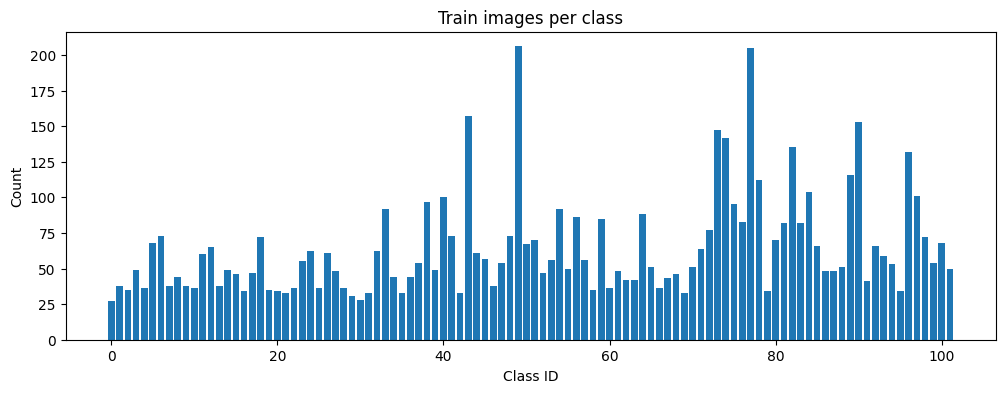

In [22]:
# Lấy toàn bộ label trong train_set
labels = [train_set[i][1] for i in range(len(train_set))]

cnt = Counter(labels)

plt.figure(figsize=(12,4))
plt.bar(cnt.keys(), cnt.values())
plt.title("Train images per class")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()


In [24]:
train_augment = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_augment = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


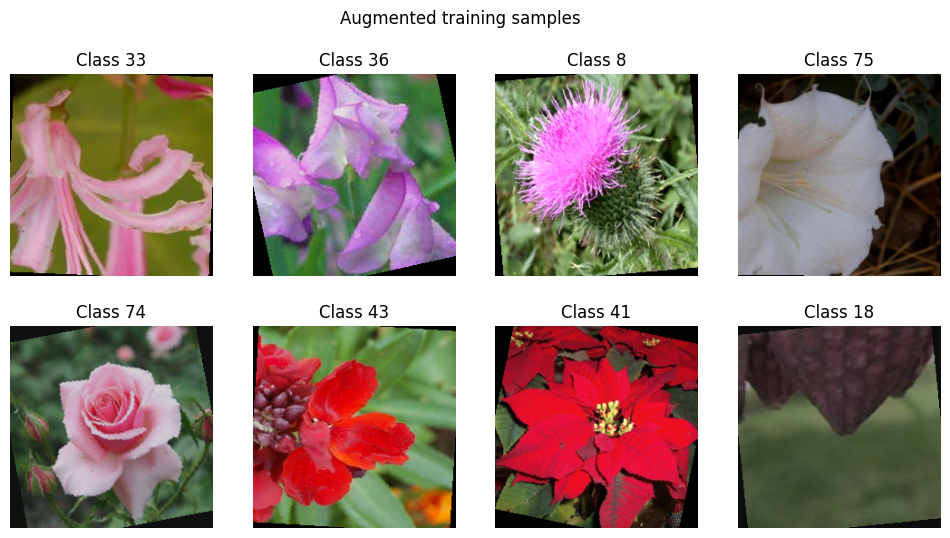

In [26]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

plt.figure(figsize=(12,6))
for i in range(min(8, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img * IMAGENET_STD) + IMAGENET_MEAN
    img = img.clip(0, 1)

    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(f"Class {labels[i].item()}")
    plt.axis("off")

plt.suptitle("Augmented training samples")
plt.show()


In [12]:
CAT_TO_NAME_PATH = "/kaggle/input/pytorch-challange-flower-dataset/cat_to_name.json"

# folder_id (str: "1"–"102") → flower name
with open(CAT_TO_NAME_PATH, "r") as f:
    folder_to_name = json.load(f)

print("Loaded flower names:", len(folder_to_name))

# ImageFolder mapping: folder_id ("1"–"102") → class index (0–101)
folder_to_idx = train_set.class_to_idx

# class index (0–101) → folder_id ("1"–"102")
idx_to_folder = {idx: folder for folder, idx in folder_to_idx.items()}

# class index (0–101) → flower name
idx_to_name = {
    idx: folder_to_name[folder]
    for idx, folder in idx_to_folder.items()
}

print("Example index → name:", list(idx_to_name.items())[:3])


Loaded flower names: 102
Example index → name: [(0, 'pink primrose'), (1, 'globe thistle'), (2, 'blanket flower')]


In [13]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize(img):
    return img * std + mean


def show_samples(dataset, class_idx, n=5):
    imgs = [img for img, label in dataset if label == class_idx][:n]

    flower_name = idx_to_name.get(class_idx, "Unknown")

    plt.figure(figsize=(12, 3))
    for i, img in enumerate(imgs):
        img = unnormalize(img)
        plt.subplot(1, n, i + 1)
        plt.imshow(img.permute(1, 2, 0).clamp(0,1))
        plt.axis("off")

    plt.suptitle(f"Class {class_idx}: {flower_name}")
    plt.show()


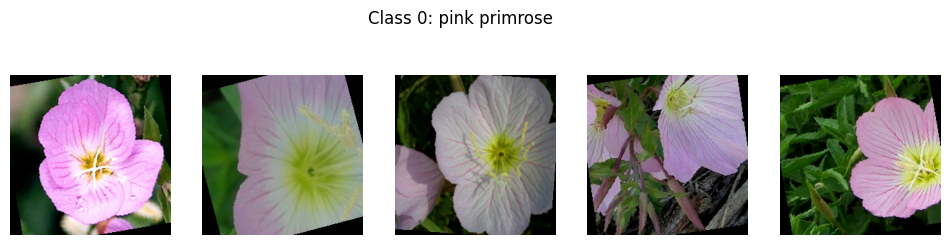

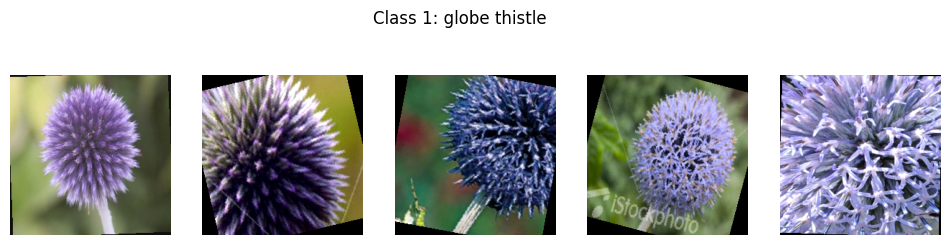

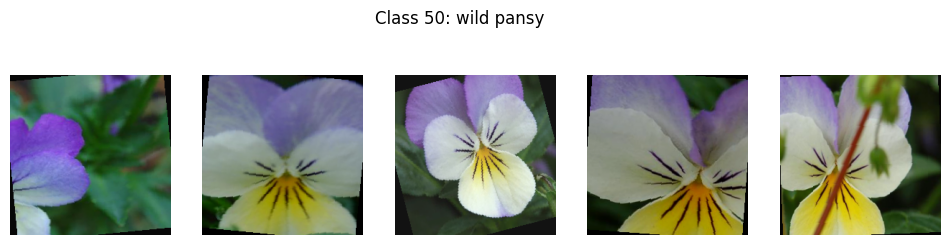

In [ ]:
show_samples(train_set, class_idx=0, n=5)
show_samples(train_set, class_idx=1, n=5)
show_samples(train_set, class_idx=50, n=5)


In [ ]:
def build_convnext_model(
    num_classes: int,
    device: torch.device,
    pretrained: bool = True,
    freeze_backbone: bool = True
):
    """
    Build ConvNeXt-Base model for fine-tuning on Flowers102 (Kaggle).

    Args:
        num_classes (int): number of output classes (102)
        device (torch.device): cuda / cpu
        pretrained (bool): use ImageNet pretrained weights
        freeze_backbone (bool): freeze feature extractor (for transfer learning)

    Returns:
        model (nn.Module)
    """

    # ConvNeXt Base
    weights = (
        models.ConvNeXt_Base_Weights.IMAGENET1K_V1
        if pretrained else None
    )

    model = models.convnext_base(weights=weights)

    # Freeze backbone
    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False

    # Replace classifier head
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)

    # Move to device
    model = model.to(device)

    return model


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 102

model = build_convnext_model(
    num_classes=NUM_CLASSES,
    device=DEVICE,
    pretrained=True,
    freeze_backbone=True   # Epoch đầu: train head
)

print(model)


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:04<00:00, 75.7MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
#FREEZE / UNFREEZE

def freeze_backbone(model):
    """
    Freeze ConvNeXt backbone, chỉ train classifier
    """
    for name, param in model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False


def unfreeze_convnext_backbone(model, lr=1e-4):
    """
    Unfreeze ConvNeXt backbone để fine-tune
    """
    for param in model.features.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=1e-4
    )

    print(">>> ConvNeXt backbone UNFROZEN")
    return optimizer



In [18]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


In [19]:
def topk_accuracy(output, target, k=5):
    _, pred = output.topk(k, dim=1)
    correct = (pred == target.view(-1, 1)).any(dim=1)
    return correct.sum().item()


In [ ]:
# WANDB INIT
wandb.init(
    project="CNN-Flower-Classification",
    name="ConvNeXt-Freeze-Unfreeze",
)

# CONFIG
SAVE_DIR = "/content/checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

writer = SummaryWriter("/content/runs/flowers102")

best_acc = 0.0
best_state = None
scheduler = None

#FREEZE BACKBONE
for p in model.features.parameters():
    p.requires_grad = False

# OPTIMIZER
optimizer = torch.optim.AdamW(
    model.classifier.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# TRAIN LOOP
for epoch in range(EPOCHS):
    start_time = time.time()

    # UNFREEZE + RESET OPTIMIZER
    if epoch == FREEZE_EPOCHS:
        for p in model.features.parameters():
            p.requires_grad = True

        optimizer = torch.optim.AdamW(
            [
                {"params": model.features.parameters(), "lr": 5e-5},
                {"params": model.classifier.parameters(), "lr": 1e-4},
            ],
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=EPOCHS - FREEZE_EPOCHS,
            eta_min=1e-6
        )

        print(">>> Backbone unfrozen | Optimizer reset (2 LR)")

    phase = "freeze" if epoch < FREEZE_EPOCHS else "unfreeze"

    # TRAIN
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total

    # VALID
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    if scheduler is not None:
        scheduler.step()

    epoch_time = time.time() - start_time

    # WANDB LOG
    log_data = {
        "epoch": epoch + 1,
        "phase": phase,
        "train/loss": train_loss,
        "train/acc": train_acc,
        "val/loss": val_loss,
        "val/acc": val_acc,
        "epoch_time": epoch_time,
    }

    if phase == "freeze":
        log_data["lr/head"] = optimizer.param_groups[0]["lr"]
    else:
        log_data["lr/backbone"] = optimizer.param_groups[0]["lr"]
        log_data["lr/head"] = optimizer.param_groups[1]["lr"]

    wandb.log(log_data, step=epoch + 1)

    # PRINT LOG
    print(
            f"Epoch [{epoch+1}/{EPOCHS}] | "
            f"Phase: {phase} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.4f}"
    )

    # SAVE
    if val_acc > best_acc:
        best_acc = val_acc
        best_state = copy.deepcopy(model.state_dict())
        wandb.run.summary["best_val_acc"] = best_acc

# SAVE CHECKPOINT
MODEL_PATH = f"{SAVE_DIR}/best_convnext.pth"

torch.save(
    {
        "model_state_dict": best_state,
        "best_acc": best_acc
    },
    MODEL_PATH
)

print("\nTraining done")
print(f"Best Val Acc: {best_acc:.4f}")
print("Files:", os.listdir(SAVE_DIR))

wandb.finish()


Epoch [1/20] | Phase: freeze | Train Loss: 4.3113 | Val Loss: 3.9178 | Val Acc: 0.2555
Epoch [2/20] | Phase: freeze | Train Loss: 3.7664 | Val Loss: 3.3950 | Val Acc: 0.4364
Epoch [3/20] | Phase: freeze | Train Loss: 3.3175 | Val Loss: 2.9496 | Val Acc: 0.5355
Epoch [4/20] | Phase: freeze | Train Loss: 2.9241 | Val Loss: 2.5820 | Val Acc: 0.6271
Epoch [5/20] | Phase: freeze | Train Loss: 2.6123 | Val Loss: 2.2860 | Val Acc: 0.7249
>>> Backbone unfrozen | Optimizer reset (2 LR)
Epoch [6/20] | Phase: unfreeze | Train Loss: 1.5001 | Val Loss: 1.0766 | Val Acc: 0.9633
Epoch [7/20] | Phase: unfreeze | Train Loss: 1.1452 | Val Loss: 0.9880 | Val Acc: 0.9890
Epoch [8/20] | Phase: unfreeze | Train Loss: 1.0605 | Val Loss: 0.9535 | Val Acc: 0.9927
Epoch [9/20] | Phase: unfreeze | Train Loss: 0.9991 | Val Loss: 0.9343 | Val Acc: 0.9927
Epoch [10/20] | Phase: unfreeze | Train Loss: 0.9802 | Val Loss: 0.9132 | Val Acc: 0.9914
Epoch [11/20] | Phase: unfreeze | Train Loss: 0.9515 | Val Loss: 0.9006 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▁▁▁▁▁███████████████
lr/backbone,██▇▇▆▆▅▄▃▃▂▂▁▁▁
lr/head,███████▇▇▆▆▅▄▃▃▂▂▁▁▁
train/acc,▁▃▄▅▅▇██████████████
train/loss,█▇▆▅▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▃▄▅▅███████████████
val/loss,█▇▆▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,0.99633
epoch,20
epoch_time,274.79589


In [21]:
# EVALUATION
model.eval()
y_true, y_pred = [], []
top5_correct = 0
total_samples = 0

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(x)

        # Top-1 prediction
        preds = logits.argmax(dim=1)

        # Top-5 prediction
        top5 = torch.topk(logits, k=5, dim=1).indices

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Top-5 accuracy count
        for i in range(y.size(0)):
            if y[i] in top5[i]:
                top5_correct += 1

        total_samples += y.size(0)

# METRICS
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")
top5_acc = top5_correct / total_samples

print("Evaluation Results")
print(f"Accuracy (Top-1) : {acc:.4f}")
print(f"Top-5 Accuracy  : {top5_acc:.4f}")
print(f"F1-score macro  : {f1_macro:.4f}")
print(f"F1-score weight : {f1_weighted:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation Results
Accuracy (Top-1) : 0.9963
Top-5 Accuracy  : 0.9988
F1-score macro  : 0.9961
F1-score weight : 0.9963


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        out = model(x)
        preds = out.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

cm = confusion_matrix(all_labels, all_preds)

print("Confusion matrix shape:", cm.shape)


Confusion matrix shape: (102, 102)


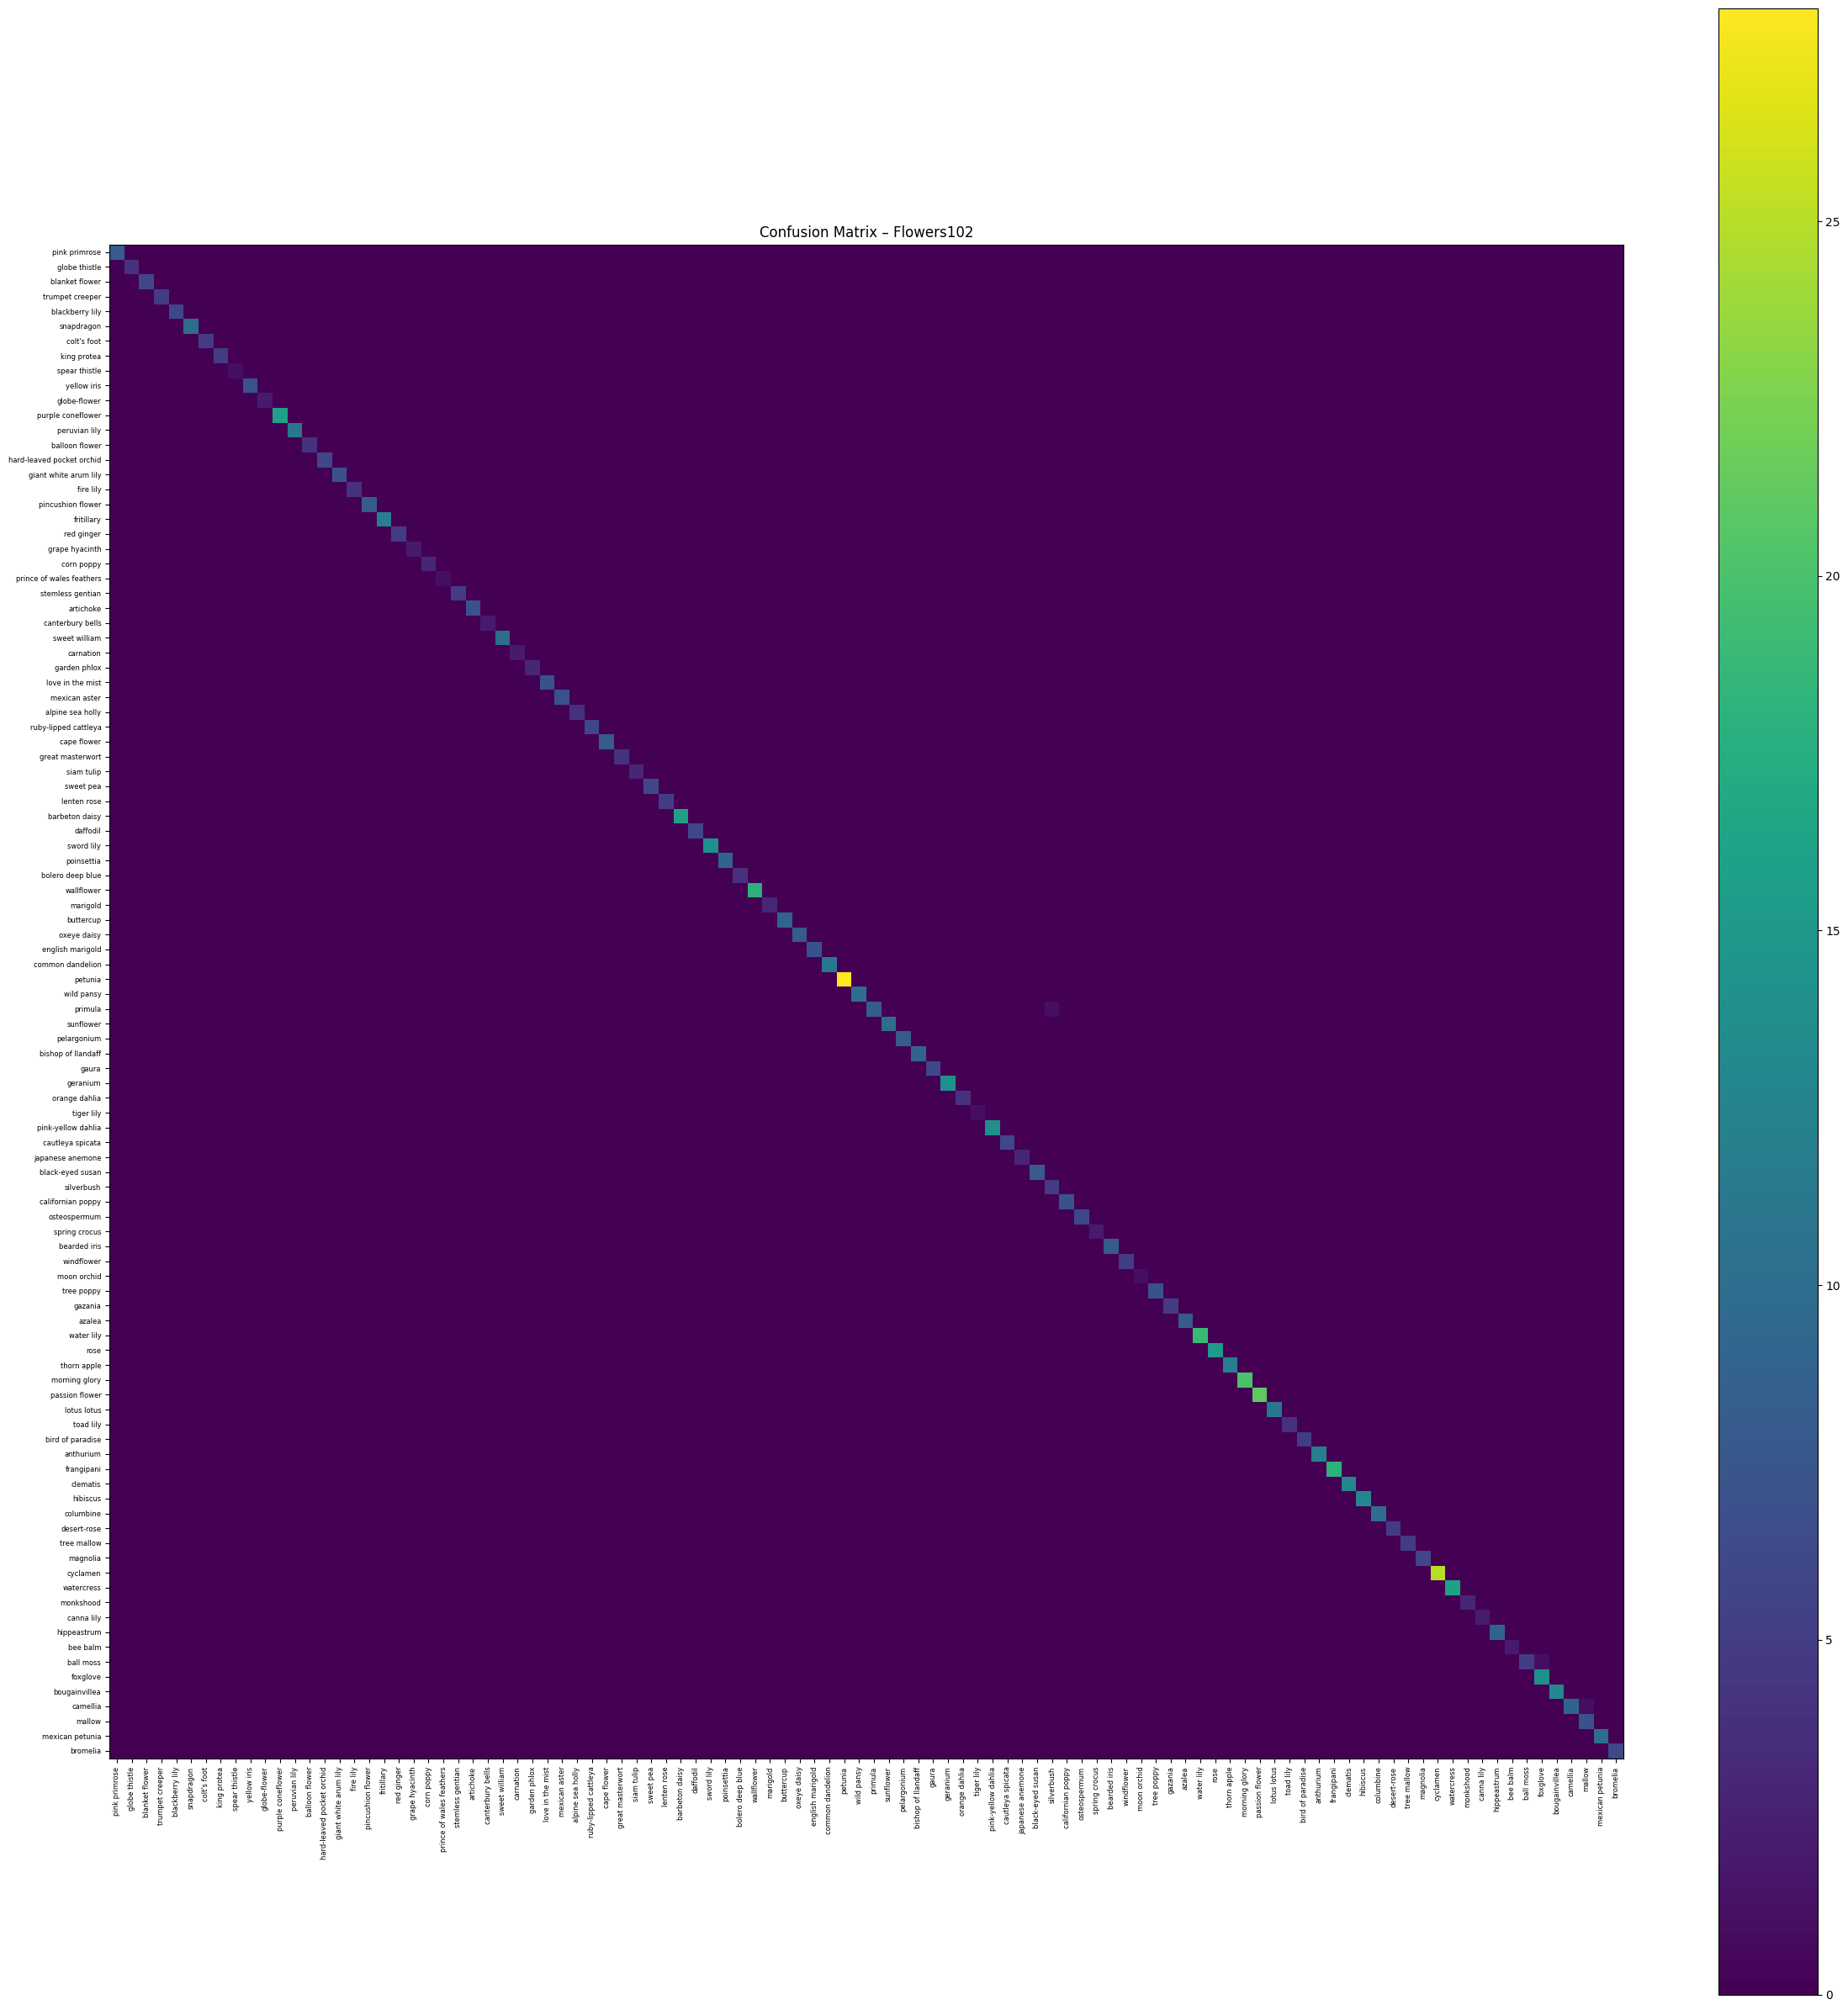

In [ ]:
import matplotlib.pyplot as plt

class_names = [idx_to_name[i] for i in range(102)]

plt.figure(figsize=(24, 24))
plt.imshow(cm)
plt.title("Confusion Matrix – Flowers102")
plt.colorbar()

plt.xticks(range(102), class_names, rotation=90, fontsize=6)
plt.yticks(range(102), class_names, fontsize=6)

plt.tight_layout()
plt.show()


In [ ]:
def recognize(model, img, topk=5):
    model.eval()
    with torch.no_grad():
        x = img.unsqueeze(0).to(DEVICE)   # [1, C, H, W]
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        topk = probs.topk(topk, dim=1)
    return topk


Ground truth: colt's foot
Top-5 predictions:
1. colt's foot - 98.24%
2. common dandelion - 0.15%
3. spring crocus - 0.09%
4. tree poppy - 0.08%
5. globe-flower - 0.08%


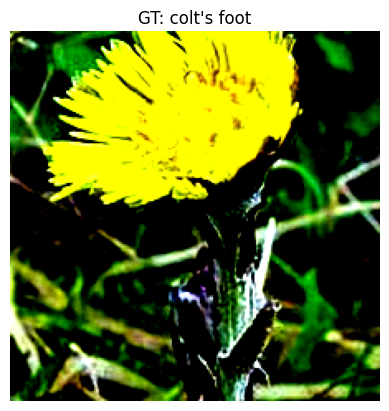

In [ ]:

idx = random.randint(0, len(val_set) - 1)
img, label = val_set[idx]

top5 = recognize(model, img)

print(f"Ground truth: {idx_to_name[label]}")
print("Top-5 predictions:")

for i in range(5):
    cid  = top5.indices[0][i].item()     # class index
    conf = top5.values[0][i].item() * 100

    flower_name = idx_to_name[cid]

    print(f"{i+1}. {flower_name} - {conf:.2f}%")


plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.title(f"GT: {idx_to_name[label]}")
plt.axis("off")
plt.show()


Top-5 predictions:
1. rose - 84.26%
2. carnation - 0.75%
3. cyclamen - 0.72%
4. globe-flower - 0.68%
5. geranium - 0.47%


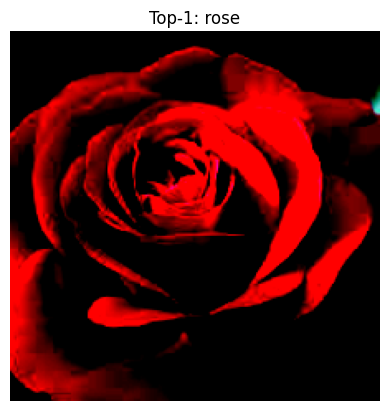

In [ ]:
# PREDICT SINGLE IMAGE (USER INPUT)

# Input user's image path
IMAGE_PATH = "/content/image5.jpg"

# Load image
img_pil = Image.open(IMAGE_PATH).convert("RGB")

# Transform giống validation / test
img_tensor = val_tf(img_pil).unsqueeze(0).to(DEVICE)

# Predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    probs = torch.softmax(output, dim=1)
    top5 = torch.topk(probs, k=5)

print("Top-5 predictions:")
for i in range(5):
    cid = top5.indices[0][i].item()
    conf = top5.values[0][i].item() * 100
    print(f"{i+1}. {idx_to_name[cid]} - {conf:.2f}%")

# Plot image
plt.imshow(img_tensor[0].permute(1,2,0).cpu().clamp(0,1))
plt.title(f"Top-1: {idx_to_name[top5.indices[0][0].item()]}")
plt.axis("off")
plt.show()
